# INIT
1. Installation of required libraries
2. Libraries import
3. Creation of utility function to display images
3. Model's loading

In [1]:
!pip install openai-clip

In [196]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import cv2
from scipy.ndimage import gaussian_filter

In [174]:
import torch
import torch.nn.functional as F
from torchvision import datasets
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy, multiclass_precision, multiclass_recall, multiclass_auroc, binary_accuracy, binary_f1_score, binary_recall, binary_precision, binary_auroc
import clip
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [4]:
print(torch.__version__)
print(np.__version__)

2.2.2
1.26.4


In [323]:
labels = ['no diabetic retinopathy', 
          'mild diabetic retinopathy',
         'moderate diabetic retinopathy',
         'severe diabetic retinopathy',
         'proliferative diabetic retinopathy']

In [6]:
def imshow(image, ax=None, title=None, normalize=False):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)
    return ax

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [140]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [424]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [142]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x1365b7ec0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [143]:
model

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

## Checking CLIP
Run model on one image to see if everything was correctly configured


In [144]:
train = datasets.ImageFolder('./APTOS2019/train', transform=preprocess)

In [145]:
dataloader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)

In [146]:
images, y = next(iter(dataloader))

In [147]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c} fundus") for c in labels]).to(device)

In [148]:
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(images[0].unsqueeze(0))
    text_features = model.encode_text(text_inputs)

In [149]:
# Pick the top n most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(len(labels))

In [150]:
# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{labels[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

moderate diabetic retinopathy: 27.52%
no diabetic retinopathy: 22.00%
mild diabetic retinopathy: 17.82%
severe diabetic retinopathy: 17.75%
proliferative diabetic retinopathy: 14.91%


<Axes: title={'center': 'mild diabetic retinopathy'}>

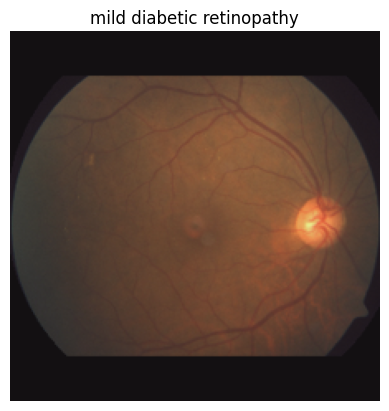

In [151]:
imshow(images[0], title=f'{labels[int(y[0])]}', normalize=True)

# Zero-shot Image Classification with CLIP

Check potential of pretrained CLIP

[Source](https://www.pinecone.io/learn/series/image-search/zero-shot-image-classification-clip/)

In [425]:
test = datasets.ImageFolder('./APTOS2019/test', transform=preprocess)

In [426]:
dataloader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [427]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c} fundus") for c in labels]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
text_features /= text_features.norm(dim=-1, keepdim=True)

In [428]:
y_true = np.ones((len(test))).astype(np.int64)*-1
y_pred = np.empty((len(test),len(labels))).astype(np.float64)
for idx, (image, label) in enumerate(dataloader):
    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image[0].unsqueeze(0))
    image_features /= image_features.norm(dim=-1, keepdim=True)
    y_pred[idx,:] = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    y_true[idx]=label[0]

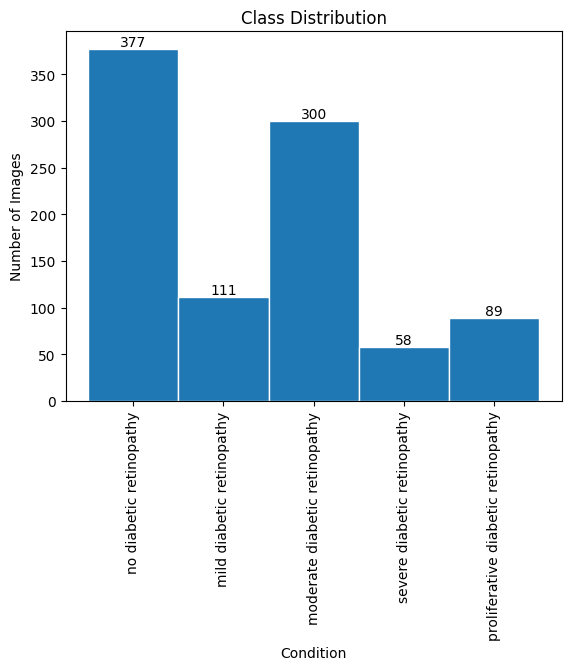

In [429]:

values, bins, bars = plt.hist(y_true,bins=[0,1,2,3,4,5],edgecolor='white')
plt.xlabel("Condition")
plt.ylabel("Number of Images")
plt.title('Class Distribution')
plt.bar_label(bars)
plt.xticks([0.5,1.5,2.5,3.5,4.5],labels=labels, rotation=90)
plt.show()

## Results

In [430]:
y_pred_cls = np.argmax(y_pred,axis=1)

<Figure size 1000x1000 with 0 Axes>

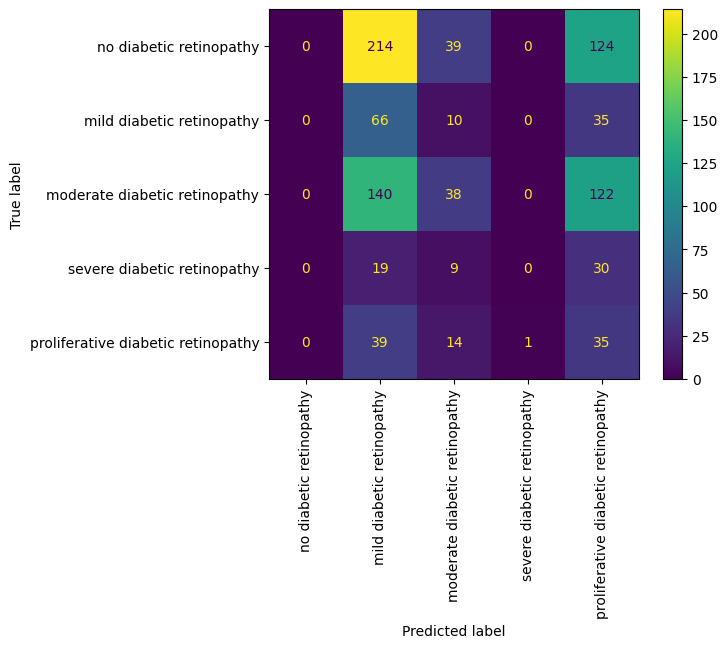

In [431]:
cm = confusion_matrix(y_true,y_pred_cls)
plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot(xticks_rotation='vertical')
plt.show()

In [ ]:
multiclass_accuracy(torch.from_numpy(y_pred), torch.from_numpy(y_true), num_classes=5,average=None)

/opt/anaconda3/envs/oculomics/lib/python3.12/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403213615/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:235.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


tensor([0.2599, 0.0000, 0.9733, 0.0000, 0.0000])

In [163]:
multiclass_precision(torch.from_numpy(y_pred), torch.from_numpy(y_true), num_classes=5, average=None)

tensor([0.9423, 0.0000, 0.3710, 0.0000, 0.0000])

In [164]:
multiclass_recall(torch.from_numpy(y_pred), torch.from_numpy(y_true), num_classes=5,average=None)

tensor([0.2599, 0.0000, 0.9733, 0.0000, 0.0000])

In [165]:
multiclass_f1_score(torch.from_numpy(y_pred), torch.from_numpy(y_true), num_classes=5, average=None)

tensor([0.4075, 0.0000, 0.5373, 0.0000, 0.0000])

In [166]:
multiclass_auroc(torch.from_numpy(y_pred),torch.from_numpy(y_true), num_classes=5, average=None)

tensor([0.7804, 0.4382, 0.6521, 0.3985, 0.4658])

In [167]:
np.sum(y_true == y_pred_cls)/len(y_true)

0.41711229946524064

In [169]:
print(
    f' Accuracy: {multiclass_accuracy(torch.from_numpy(y_pred), torch.from_numpy(y_true))}\n',
    f'Precision: {multiclass_precision(torch.from_numpy(y_pred), torch.from_numpy(y_true))}\n',
    f'Recall: {multiclass_recall(torch.from_numpy(y_pred), torch.from_numpy(y_true))}\n',
    f'F1-score (weighted): {multiclass_f1_score(torch.from_numpy(y_pred), torch.from_numpy(y_true), num_classes=5, average='weighted')}\n',
    f'AUROC: {multiclass_auroc(torch.from_numpy(y_pred),torch.from_numpy(y_true), num_classes=5)}'
)

 Accuracy: 0.4171122908592224
 Precision: 0.4171122908592224
 Recall: 0.4171122908592224
 F1-score (weighted): 0.33668363094329834
 AUROC: 0.5470068454742432


## Binary classification

### Threshold

In [ ]:
bin_y_true = y_true.copy()


In [220]:
bin_y_true[bin_y_true > 0] = 1

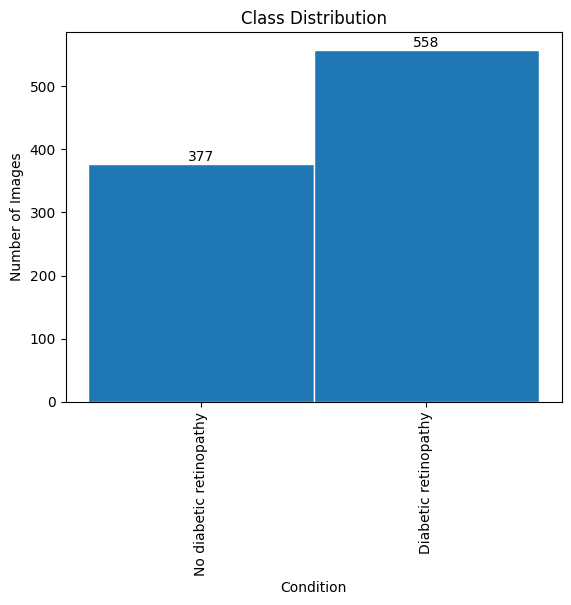

In [221]:
values, bins, bars = plt.hist(bin_y_true,bins=[0,1,2],edgecolor='white')
plt.xlabel("Condition")
plt.ylabel("Number of Images")
plt.title('Class Distribution')
plt.bar_label(bars)
plt.xticks([0.5,1.5],labels=['No diabetic retinopathy', 'Diabetic retinopathy'], rotation=90)
plt.show()

In [ ]:
bin_y_true = y_true.copy()
bin_y_true[bin_y_true > 0] = 1

In [ ]:
print(
    f' Accuracy: {binary_accuracy(torch.from_numpy(y_pred_cls), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'Precision: {binary_precision(torch.from_numpy(y_pred_cls), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'Recall: {binary_recall(torch.from_numpy(y_pred_cls), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'F1-score: {binary_f1_score(torch.from_numpy(y_pred_cls), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'AUROC: {binary_auroc(torch.from_numpy(bin_y_pred),torch.from_numpy(bin_y_true))}'
)

 Accuracy: 0.6951871514320374
 Precision: 0.6642599105834961
 Recall: 0.9892473220825195
 F1-score: 0.7948164343833923
 AUROC: 0.6245971307150395


<Figure size 1000x1000 with 0 Axes>

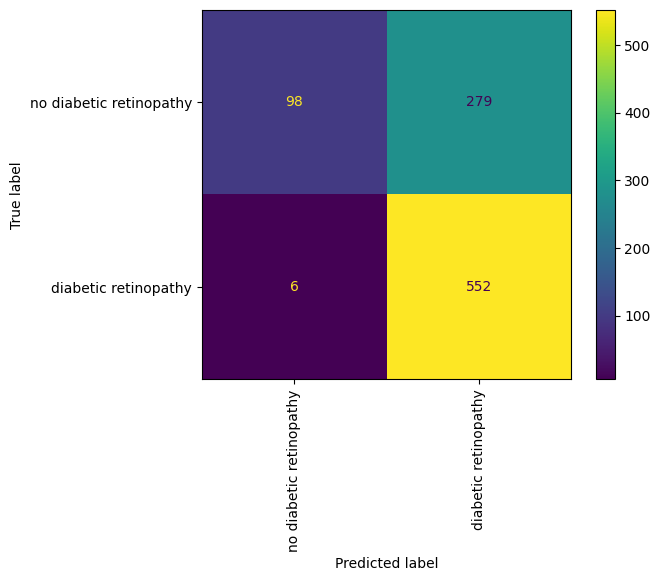

In [225]:
cm = confusion_matrix(bin_y_true,bin_y_pred)
plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no diabetic retinopathy','diabetic retinopathy'])
disp.plot(xticks_rotation='vertical')
plt.show()

## Binary labels
Another approach to binary classification

In [226]:
binary_labels = [
    'no diabetic retinopathy',
    'diabetic retinopathy'
]

In [227]:
binary_text_inputs = torch.cat([clip.tokenize(f"a photo of a {c} fundus") for c in binary_labels]).to(device)
with torch.no_grad():
    binary_text_features = model.encode_text(binary_text_inputs)
binary_text_features /= binary_text_features.norm(dim=-1, keepdim=True)

In [228]:
bin_y_pred = np.ones((len(test))).astype(np.int32)*-1
for idx, (image, label) in enumerate(dataloader):
    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image[0].unsqueeze(0))
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ binary_text_features.T).softmax(dim=-1)
    bin_y_pred[idx] = np.argmax(similarity)

In [229]:
print(
    f' Accuracy: {binary_accuracy(torch.from_numpy(bin_y_pred), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'Precision: {binary_precision(torch.from_numpy(bin_y_pred), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'Recall: {binary_recall(torch.from_numpy(bin_y_pred), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'F1-score: {binary_f1_score(torch.from_numpy(bin_y_pred.astype(np.int64)), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'AUROC: {binary_auroc(torch.from_numpy(bin_y_pred),torch.from_numpy(bin_y_true))}'
)

 Accuracy: 0.5807486772537231
 Precision: 0.6159217953681946
 Recall: 0.7903226017951965
 F1-score: 0.692307710647583
 AUROC: 0.53043980491144


<Figure size 1000x1000 with 0 Axes>

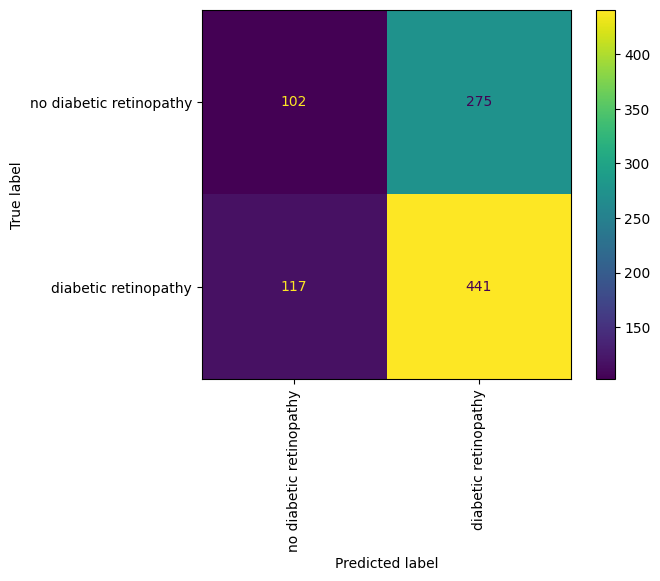

In [231]:
cm = confusion_matrix(bin_y_true,bin_y_pred)
plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no diabetic retinopathy','diabetic retinopathy'])
disp.plot(xticks_rotation='vertical')
plt.show()

In [232]:
thresh_y_pred = y_pred_cls.copy()

In [233]:
thresh_y_pred[thresh_y_pred>0]=1

In [234]:
np.sum(thresh_y_pred == bin_y_pred)/len(thresh_y_pred)

0.7700534759358288

### Another approach

In [235]:
binary_labels_2 = [
    'healthy',
    'diabetic retinopathy'
]

In [236]:
binary_text_inputs_2 = torch.cat([clip.tokenize(f"a photo of a {c} fundus") for c in binary_labels_2]).to(device)
with torch.no_grad():
    binary_text_features_2 = model.encode_text(binary_text_inputs_2)
binary_text_features_2 /= binary_text_features_2.norm(dim=-1, keepdim=True)

In [237]:
bin_y_pred_2 = np.ones((len(test))).astype(np.int32)*-1
for idx, (image, label) in enumerate(dataloader):
    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image[0].unsqueeze(0))
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ binary_text_features_2.T).softmax(dim=-1)
    bin_y_pred_2[idx] = np.argmax(similarity)

In [238]:
print(
    f' Accuracy: {binary_accuracy(torch.from_numpy(bin_y_pred_2), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'Precision: {binary_precision(torch.from_numpy(bin_y_pred_2), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'Recall: {binary_recall(torch.from_numpy(bin_y_pred_2), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'F1-score: {binary_f1_score(torch.from_numpy(bin_y_pred_2.astype(np.int64)), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'AUROC: {binary_auroc(torch.from_numpy(bin_y_pred_2),torch.from_numpy(bin_y_true))}'
)

 Accuracy: 0.5967914462089539
 Precision: 0.5967914462089539
 Recall: 1.0
 F1-score: 0.747488260269165
 AUROC: 0.5


<Figure size 1000x1000 with 0 Axes>

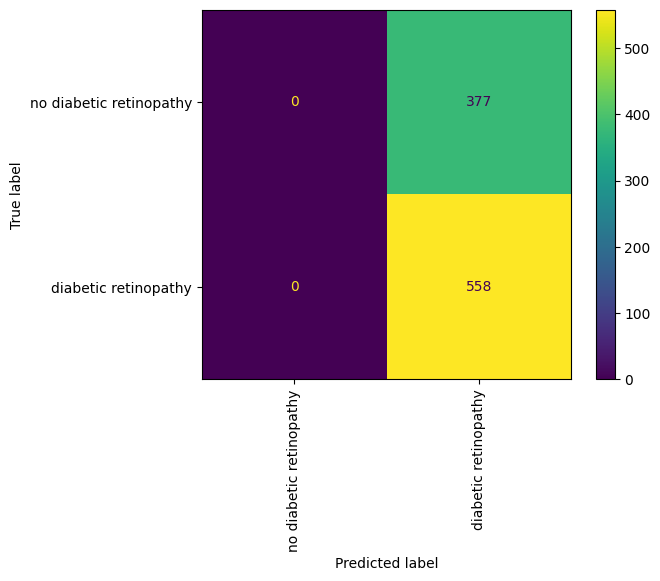

In [239]:
cm = confusion_matrix(bin_y_true,bin_y_pred_2)
plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no diabetic retinopathy','diabetic retinopathy'])
disp.plot(xticks_rotation='vertical')
plt.show()

In [240]:
np.sum(bin_y_pred_2 == bin_y_pred)/len(bin_y_pred)

0.7657754010695187

In [241]:
np.sum(bin_y_pred_2 == thresh_y_pred)/len(bin_y_pred)

0.8887700534759359

How to present two loss functions and saliency maps of CLIP when it's not opensource?

https://github.com/pranavgupta2603/CLIP-ViL-GradCAM/blob/main/gradcam_clip.ipynb

# GradCAM
[Source](https://colab.research.google.com/github/kevinzakka/clip_playground/blob/main/CLIP_GradCAM_Visualization.ipynb#scrollTo=_bSzlC60WVkQ)

In [432]:
#@title Helper functions

#@markdown Some helper functions for overlaying heatmaps on top
#@markdown of images and visualizing with matplotlib.

def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

# Modified from: https://github.com/salesforce/ALBEF/blob/main/visualization.ipynb
def getAttMap(img, attn_map, blur=True):
    if blur:
        attn_map = gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('jet')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def viz_attn(img, attn_map, blur=True):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.show()
    
def load_image(image, resize=None):
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.

In [433]:
#@title GradCAM: Gradient-weighted Class Activation Mapping

#@markdown Our gradCAM implementation registers a forward hook
#@markdown on the model at the specified layer. This allows us
#@markdown to save the intermediate activations and gradients
#@markdown at that layer.

#@markdown To visualize which parts of the image activate for
#@markdown a given caption, we use the caption as the target
#@markdown label and backprop through the network using the
#@markdown image as the input.
#@markdown In the case of CLIP models with resnet encoders,
#@markdown we save the activation and gradients at the
#@markdown layer before the attention pool, i.e., layer4.

class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: torch.nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)
        
    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()
        
    @property
    def activation(self) -> torch.Tensor:
        return self.data
    
    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad


# Reference: https://arxiv.org/abs/1610.02391
def gradCAM(
    model: torch.nn.Module,
    input: torch.Tensor,
    target: torch.Tensor,
    layer: torch.nn.Module
) -> torch.Tensor:
    # Zero out any gradients at the input.
    if input.grad is not None:
        input.grad.data.zero_()
        
    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)
        
    # Attach a hook to the model at the desired layer.
    assert isinstance(layer, torch.nn.Module)
    with Hook(layer) as hook:        
        # Do a forward and backward pass.
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()
    
        # Global average pool gradient across spatial dimension
        # to obtain importance weights.
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        # Weighted combination of activation maps over channel
        # dimension.
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        # We only want neurons with positive influence so we
        # clamp any negative ones.
        gradcam = torch.clamp(gradcam, min=0)

    # Resize gradcam to input resolution.
    gradcam = F.interpolate(
        gradcam,
        input.shape[2:],
        mode='bicubic',
        align_corners=False)
    
    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])
        
    return gradcam

In [434]:
data_path = "./APTOS2019/test"

In [435]:
im1 = Image.open(os.path.join(data_path,'anodr','5a27b9b2a9c1.png'))
im2 = Image.open(os.path.join(data_path,'bmilddr','1bb0ddfe753a.png'))
im3 = Image.open(os.path.join(data_path,'cmoderatedr','2ba0b0d9bda2.png'))
im4 = Image.open(os.path.join(data_path,'dseveredr','80e7cc0a0649.png'))
im5 = Image.open(os.path.join(data_path,'eproliferativedr','0e0fc1d9810c.png'))

In [436]:
clip_model = "RN50" #@param ["RN50", "RN101", "RN50x4", "RN50x16"]
saliency_layer = "layer4" #@param ["layer4", "layer3", "layer2", "layer1"]
blur = True #@param {type:"boolean"}
model, preprocess = clip.load(clip_model, device=device, jit=False)

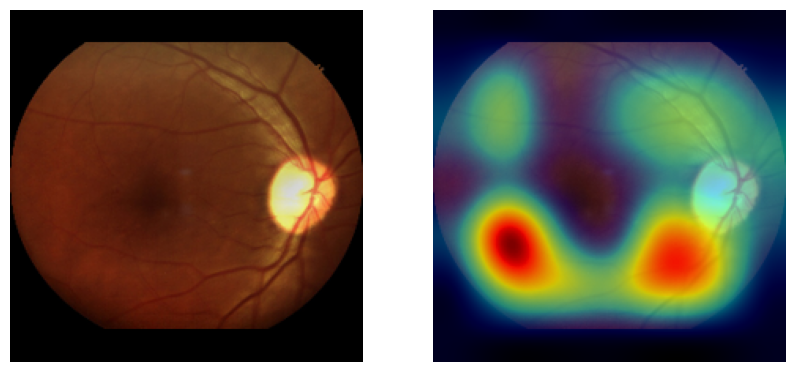

In [437]:
image_input = preprocess(im1).unsqueeze(0).to(device)
image_np = load_image(im1, model.visual.input_resolution)
text_input = clip.tokenize([labels[0]]).to(device)

attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)

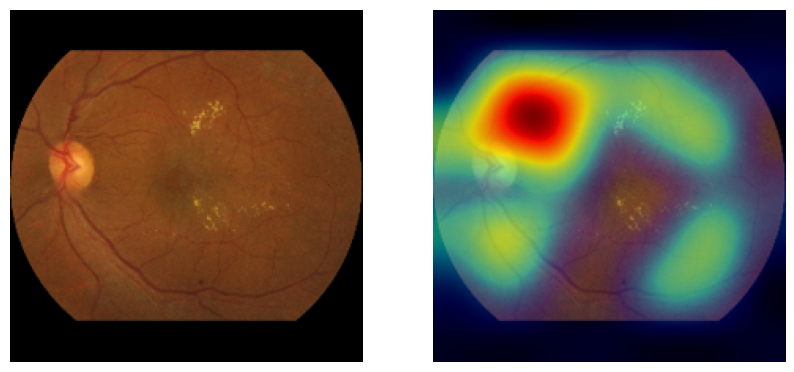

In [443]:
image_input = preprocess(im2).unsqueeze(0).to(device)
image_np = load_image(im2, model.visual.input_resolution)
text_input = clip.tokenize([labels[1]]).to(device)

attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)

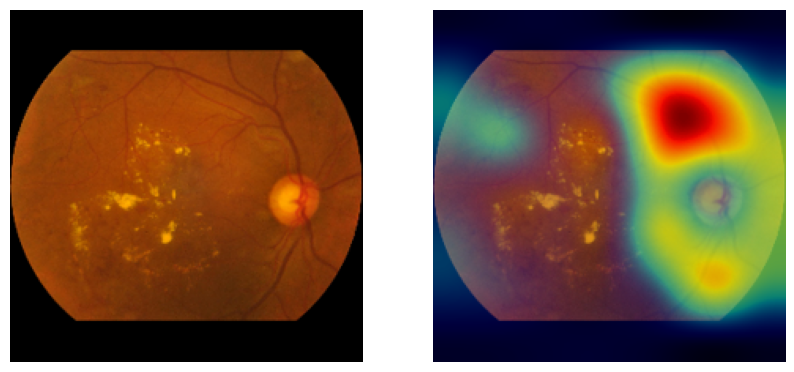

In [444]:
image_input = preprocess(im3).unsqueeze(0).to(device)
image_np = load_image(im3, model.visual.input_resolution)
text_input = clip.tokenize([labels[2]]).to(device)

attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)

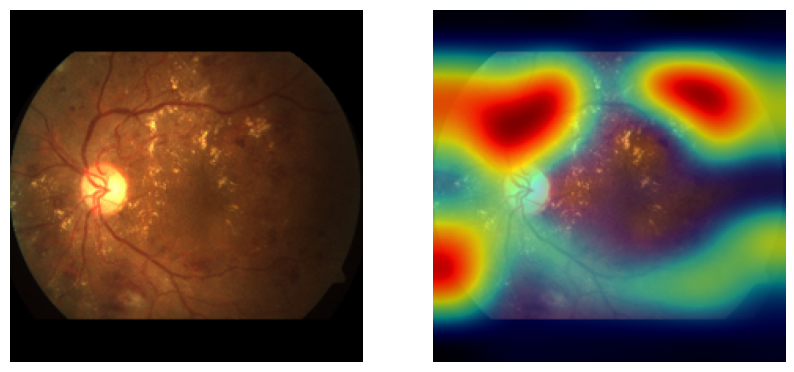

In [445]:
image_input = preprocess(im4).unsqueeze(0).to(device)
image_np = load_image(im4, model.visual.input_resolution)
text_input = clip.tokenize([labels[3]]).to(device)

attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)

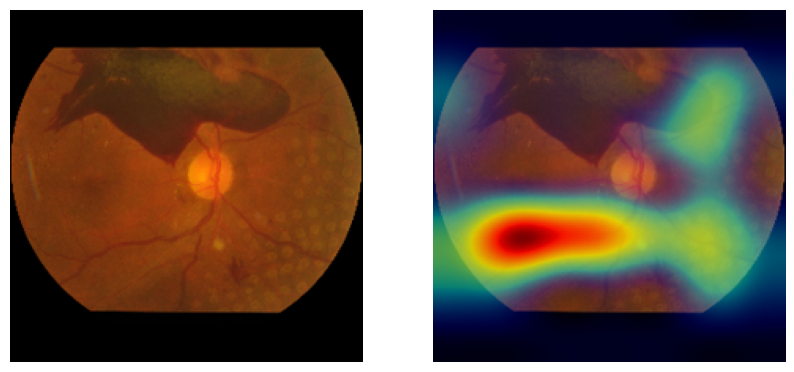

In [446]:
image_input = preprocess(im5).unsqueeze(0).to(device)
image_np = load_image(im5, model.visual.input_resolution)
text_input = clip.tokenize([labels[4]]).to(device)

attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)

[RET-CLIP:](https://arxiv.org/pdf/2405.14137)
[mBRSET](https://github.com/luisnakayama/mBRSET/tree/main)

# Fine tunning

In [388]:
# OpenAI CLIP model and preprocessing
model, preprocess = clip.load("RN50", device=device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [399]:
labels = ['no diabetic retinopathy', 
          'mild diabetic retinopathy',
         'moderate diabetic retinopathy',
         'severe diabetic retinopathy',
         'proliferative diabetic retinopathy']

In [390]:
train = datasets.ImageFolder('./APTOS2019/train', transform=preprocess)
val = datasets.ImageFolder('./APTOS2019/val', transform=preprocess)
test = datasets.ImageFolder('./APTOS2019/test', transform=preprocess)

In [391]:
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [392]:
class CLIPFineTuner(torch.nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = torch.nn.Linear(model.visual.output_dim, num_classes)
    
    def forward(self, x):
        with torch.no_grad():
            features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)

In [393]:
num_classes = len(labels)

In [394]:
model_ft = CLIPFineTuner(model, num_classes).to(device)

In [395]:
num_classes

5

In [396]:
model_ft.load_state_dict(torch.load('clip_finetuned.pth', weights_only=True))

<All keys matched successfully>

In [397]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.classifier.parameters(), lr=1e-3)

In [398]:
# Number of epochs for training
num_epochs = 50

# Training loop
for idx, epoch in enumerate(range(num_epochs)):
    model_ft.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)
        
        running_loss += loss.item()  # Update running loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")  # Update progress bar with current loss

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')  # Print average loss for the epoch

    # Validation
    model_ft.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter
    
    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
            total += labels.size(0)  # Update total samples
            correct += (predicted == labels).sum().item()  # Update correct predictions

    print(f'Validation Accuracy: {100 * correct / total}%')  # Print validation accuracy for the epoch
    # Save the fine-tuned model
    torch.save(model_ft.state_dict(), f'clip_{idx}.pth')  # Save the model's state dictionary


Epoch 1/50, Loss: 0.0000:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1/50, Loss: 0.6090: 100%|██████████| 64/64 [08:30<00:00,  7.97s/it]


Epoch [1/50], Loss: 0.6090
Validation Accuracy: 75.4863813229572%


Epoch 2/50, Loss: 0.6068: 100%|██████████| 64/64 [08:19<00:00,  7.81s/it]


Epoch [2/50], Loss: 0.6068
Validation Accuracy: 75.4863813229572%


Epoch 3/50, Loss: 0.6082: 100%|██████████| 64/64 [08:21<00:00,  7.84s/it]


Epoch [3/50], Loss: 0.6082
Validation Accuracy: 76.26459143968872%


Epoch 4/50, Loss: 0.5993: 100%|██████████| 64/64 [08:36<00:00,  8.07s/it]


Epoch [4/50], Loss: 0.5993
Validation Accuracy: 76.07003891050584%


Epoch 5/50, Loss: 0.5965: 100%|██████████| 64/64 [08:26<00:00,  7.92s/it]


Epoch [5/50], Loss: 0.5965
Validation Accuracy: 75.09727626459144%


Epoch 6/50, Loss: 0.6116: 100%|██████████| 64/64 [08:19<00:00,  7.80s/it]


Epoch [6/50], Loss: 0.6116
Validation Accuracy: 76.4591439688716%


Epoch 7/50, Loss: 0.5937: 100%|██████████| 64/64 [08:19<00:00,  7.81s/it]


Epoch [7/50], Loss: 0.5937
Validation Accuracy: 75.87548638132296%


Epoch 8/50, Loss: 0.5878: 100%|██████████| 64/64 [08:20<00:00,  7.82s/it]


Epoch [8/50], Loss: 0.5878
Validation Accuracy: 75.87548638132296%


Epoch 9/50, Loss: 0.5857: 100%|██████████| 64/64 [08:19<00:00,  7.80s/it]


Epoch [9/50], Loss: 0.5857
Validation Accuracy: 75.68093385214007%


Epoch 10/50, Loss: 0.5872: 100%|██████████| 64/64 [08:13<00:00,  7.72s/it]


Epoch [10/50], Loss: 0.5872
Validation Accuracy: 76.26459143968872%


Epoch 11/50, Loss: 0.5808: 100%|██████████| 64/64 [08:04<00:00,  7.57s/it]


Epoch [11/50], Loss: 0.5808
Validation Accuracy: 76.4591439688716%


Epoch 12/50, Loss: 0.5791: 100%|██████████| 64/64 [08:07<00:00,  7.62s/it]


Epoch [12/50], Loss: 0.5791
Validation Accuracy: 76.26459143968872%


Epoch 13/50, Loss: 0.5686: 100%|██████████| 64/64 [08:18<00:00,  7.79s/it]


Epoch [13/50], Loss: 0.5686
Validation Accuracy: 75.4863813229572%


Epoch 14/50, Loss: 0.5704: 100%|██████████| 64/64 [08:04<00:00,  7.58s/it]


Epoch [14/50], Loss: 0.5704
Validation Accuracy: 75.68093385214007%


Epoch 15/50, Loss: 0.5674: 100%|██████████| 64/64 [08:05<00:00,  7.59s/it]


Epoch [15/50], Loss: 0.5674
Validation Accuracy: 76.26459143968872%


Epoch 16/50, Loss: 0.5685: 100%|██████████| 64/64 [08:07<00:00,  7.62s/it]


Epoch [16/50], Loss: 0.5685
Validation Accuracy: 75.87548638132296%


Epoch 17/50, Loss: 0.5673: 100%|██████████| 64/64 [08:02<00:00,  7.54s/it]


Epoch [17/50], Loss: 0.5673
Validation Accuracy: 76.26459143968872%


Epoch 18/50, Loss: 0.5587: 100%|██████████| 64/64 [08:06<00:00,  7.60s/it]


Epoch [18/50], Loss: 0.5587
Validation Accuracy: 75.4863813229572%


Epoch 19/50, Loss: 0.5592: 100%|██████████| 64/64 [08:12<00:00,  7.69s/it]


Epoch [19/50], Loss: 0.5592
Validation Accuracy: 76.07003891050584%


Epoch 20/50, Loss: 0.5541: 100%|██████████| 64/64 [08:08<00:00,  7.64s/it]


Epoch [20/50], Loss: 0.5541
Validation Accuracy: 75.87548638132296%


Epoch 21/50, Loss: 0.5526: 100%|██████████| 64/64 [07:50<00:00,  7.35s/it]


Epoch [21/50], Loss: 0.5526
Validation Accuracy: 76.26459143968872%


Epoch 22/50, Loss: 0.5427: 100%|██████████| 64/64 [07:56<00:00,  7.44s/it]


Epoch [22/50], Loss: 0.5427
Validation Accuracy: 75.68093385214007%


Epoch 23/50, Loss: 0.5439: 100%|██████████| 64/64 [07:59<00:00,  7.50s/it]


Epoch [23/50], Loss: 0.5439
Validation Accuracy: 76.07003891050584%


Epoch 24/50, Loss: 0.5488: 100%|██████████| 64/64 [08:02<00:00,  7.54s/it]


Epoch [24/50], Loss: 0.5488
Validation Accuracy: 75.87548638132296%


Epoch 25/50, Loss: 0.5423: 100%|██████████| 64/64 [08:26<00:00,  7.92s/it]


Epoch [25/50], Loss: 0.5423
Validation Accuracy: 75.68093385214007%


Epoch 26/50, Loss: 0.5411: 100%|██████████| 64/64 [08:23<00:00,  7.87s/it]


Epoch [26/50], Loss: 0.5411
Validation Accuracy: 76.84824902723736%


Epoch 27/50, Loss: 0.5292: 100%|██████████| 64/64 [08:17<00:00,  7.77s/it]


Epoch [27/50], Loss: 0.5292
Validation Accuracy: 75.29182879377431%


Epoch 28/50, Loss: 0.5335: 100%|██████████| 64/64 [08:24<00:00,  7.88s/it]


Epoch [28/50], Loss: 0.5335
Validation Accuracy: 76.4591439688716%


Epoch 29/50, Loss: 0.5409: 100%|██████████| 64/64 [08:20<00:00,  7.82s/it]


Epoch [29/50], Loss: 0.5409
Validation Accuracy: 76.4591439688716%


Epoch 30/50, Loss: 0.5297: 100%|██████████| 64/64 [08:16<00:00,  7.76s/it]


Epoch [30/50], Loss: 0.5297
Validation Accuracy: 75.68093385214007%


Epoch 31/50, Loss: 0.5361: 100%|██████████| 64/64 [08:25<00:00,  7.89s/it]


Epoch [31/50], Loss: 0.5361
Validation Accuracy: 76.26459143968872%


Epoch 32/50, Loss: 0.5316: 100%|██████████| 64/64 [08:35<00:00,  8.06s/it]


Epoch [32/50], Loss: 0.5316
Validation Accuracy: 75.09727626459144%


Epoch 33/50, Loss: 0.5357: 100%|██████████| 64/64 [08:25<00:00,  7.89s/it]


Epoch [33/50], Loss: 0.5357
Validation Accuracy: 76.07003891050584%


Epoch 34/50, Loss: 0.5261: 100%|██████████| 64/64 [08:22<00:00,  7.85s/it]


Epoch [34/50], Loss: 0.5261
Validation Accuracy: 75.87548638132296%


Epoch 35/50, Loss: 0.5327: 100%|██████████| 64/64 [08:22<00:00,  7.85s/it]


Epoch [35/50], Loss: 0.5327
Validation Accuracy: 75.87548638132296%


Epoch 36/50, Loss: 0.5291: 100%|██████████| 64/64 [08:13<00:00,  7.72s/it]


Epoch [36/50], Loss: 0.5291
Validation Accuracy: 75.68093385214007%


Epoch 37/50, Loss: 0.5160: 100%|██████████| 64/64 [08:09<00:00,  7.64s/it]


Epoch [37/50], Loss: 0.5160
Validation Accuracy: 76.26459143968872%


Epoch 38/50, Loss: 0.5171: 100%|██████████| 64/64 [08:13<00:00,  7.70s/it]


Epoch [38/50], Loss: 0.5171
Validation Accuracy: 76.07003891050584%


Epoch 39/50, Loss: 0.5138: 100%|██████████| 64/64 [08:08<00:00,  7.63s/it]


Epoch [39/50], Loss: 0.5138
Validation Accuracy: 75.4863813229572%


Epoch 40/50, Loss: 0.5204: 100%|██████████| 64/64 [08:06<00:00,  7.61s/it]


Epoch [40/50], Loss: 0.5204
Validation Accuracy: 75.87548638132296%


Epoch 41/50, Loss: 0.5091: 100%|██████████| 64/64 [08:11<00:00,  7.68s/it]


Epoch [41/50], Loss: 0.5091
Validation Accuracy: 76.4591439688716%


Epoch 42/50, Loss: 0.5110: 100%|██████████| 64/64 [08:11<00:00,  7.68s/it]


Epoch [42/50], Loss: 0.5110
Validation Accuracy: 76.26459143968872%


Epoch 43/50, Loss: 0.5041: 100%|██████████| 64/64 [07:57<00:00,  7.47s/it]


Epoch [43/50], Loss: 0.5041
Validation Accuracy: 75.4863813229572%


Epoch 44/50, Loss: 0.5069: 100%|██████████| 64/64 [07:59<00:00,  7.49s/it]


Epoch [44/50], Loss: 0.5069
Validation Accuracy: 74.70817120622569%


Epoch 45/50, Loss: 0.5146: 100%|██████████| 64/64 [08:25<00:00,  7.90s/it]


Epoch [45/50], Loss: 0.5146
Validation Accuracy: 76.26459143968872%


Epoch 46/50, Loss: 0.5012: 100%|██████████| 64/64 [08:36<00:00,  8.07s/it]


Epoch [46/50], Loss: 0.5012
Validation Accuracy: 75.4863813229572%


Epoch 47/50, Loss: 0.5049: 100%|██████████| 64/64 [08:34<00:00,  8.04s/it]


Epoch [47/50], Loss: 0.5049
Validation Accuracy: 76.65369649805447%


Epoch 48/50, Loss: 0.4984: 100%|██████████| 64/64 [08:39<00:00,  8.11s/it]


Epoch [48/50], Loss: 0.4984
Validation Accuracy: 75.68093385214007%


Epoch 49/50, Loss: 0.4963: 100%|██████████| 64/64 [08:48<00:00,  8.26s/it]


Epoch [49/50], Loss: 0.4963
Validation Accuracy: 75.68093385214007%


Epoch 50/50, Loss: 0.5011: 100%|██████████| 64/64 [08:39<00:00,  8.11s/it]


Epoch [50/50], Loss: 0.5011
Validation Accuracy: 76.4591439688716%


In [383]:
# Save the fine-tuned model
torch.save(model_ft.state_dict(), 'clip_finetuned.pth')  # Save the model's state dictionary

In [257]:
model_ft

CLIPFineTuner(
  (model): CLIP(
    (visual): ModifiedResNet(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU(inplace=True)
      (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [265]:
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c} fundus") for c in labels]).to(device)
with torch.no_grad():
    text_features = model_ft.model.encode_text(text_inputs)
text_features /= text_features.norm(dim=-1, keepdim=True)

In [448]:
y_true = np.ones((len(test))).astype(np.int64)*-1
y_pred = np.empty((len(test),len(labels))).astype(np.float64)
for idx, (image, label) in enumerate(test_loader):
    # Calculate features
    with torch.no_grad():
        y_pred[idx,:] = model_ft(image).softmax(dim=-1)
        y_true[idx]=label[0]

In [449]:
y_pred_cls = np.argmax(y_pred,axis=1)

<Figure size 1000x1000 with 0 Axes>

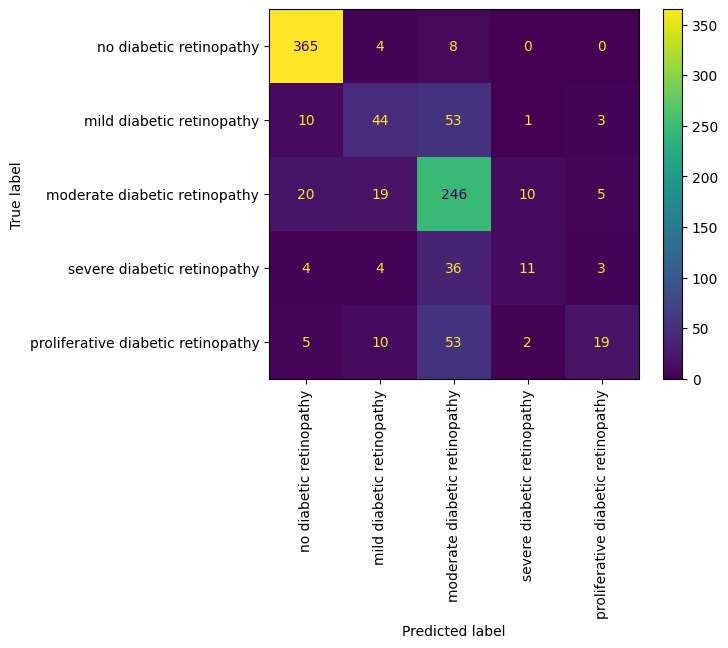

In [450]:
cm = confusion_matrix(y_true,y_pred_cls)
plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot(xticks_rotation='vertical')
plt.show()

In [409]:
image_input = preprocess(im1).unsqueeze(0).to(device)
image_np = load_image(im1, model_ft.model.visual.input_resolution)
text_input = clip.tokenize([labels[0]]).to(device)

attn_map = gradCAM(
    model_ft.model.visual,
    image_input,
    model_ft.model.encode_text(text_input).float(),
    model_ft.classifier
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [447]:
model_ft

CLIPFineTuner(
  (model): CLIP(
    (visual): ModifiedResNet(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU(inplace=True)
      (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [451]:
multiclass_accuracy(torch.from_numpy(y_pred), torch.from_numpy(y_true), num_classes=5,average=None)

tensor([0.9682, 0.3964, 0.8200, 0.1897, 0.2135])

In [452]:
multiclass_precision(torch.from_numpy(y_pred), torch.from_numpy(y_true), num_classes=5, average=None)

tensor([0.9035, 0.5432, 0.6212, 0.4583, 0.6333])

In [453]:
multiclass_recall(torch.from_numpy(y_pred), torch.from_numpy(y_true), num_classes=5,average=None)

tensor([0.9682, 0.3964, 0.8200, 0.1897, 0.2135])

In [454]:
multiclass_f1_score(torch.from_numpy(y_pred), torch.from_numpy(y_true), num_classes=5, average=None)

tensor([0.9347, 0.4583, 0.7069, 0.2683, 0.3193])

In [455]:
multiclass_auroc(torch.from_numpy(y_pred),torch.from_numpy(y_true), num_classes=5, average=None)

tensor([0.9862, 0.8931, 0.8678, 0.8376, 0.8632])

In [457]:
print(
    f' Accuracy: {multiclass_accuracy(torch.from_numpy(y_pred), torch.from_numpy(y_true))}\n',
    f'Precision: {multiclass_precision(torch.from_numpy(y_pred), torch.from_numpy(y_true))}\n',
    f'Recall: {multiclass_recall(torch.from_numpy(y_pred), torch.from_numpy(y_true))}\n',
    f'F1-score: {multiclass_f1_score(torch.from_numpy(y_pred), torch.from_numpy(y_true), num_classes=5)}\n',
    f'AUROC: {multiclass_auroc(torch.from_numpy(y_pred),torch.from_numpy(y_true), num_classes=5)}'
)

 Accuracy: 0.7326202988624573
 Precision: 0.7326202988624573
 Recall: 0.7326202988624573
 F1-score: 0.7326202988624573
 AUROC: 0.8895816802978516


In [458]:
bin_y_true = y_true.copy()
bin_y_true[bin_y_true > 0] = 1
bin_y_pred = y_pred_cls.copy()
bin_y_pred[bin_y_pred > 0] = 1

print(
    f' Accuracy: {binary_accuracy(torch.from_numpy(y_pred_cls), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'Precision: {binary_precision(torch.from_numpy(y_pred_cls), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'Recall: {binary_recall(torch.from_numpy(y_pred_cls), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'F1-score: {binary_f1_score(torch.from_numpy(y_pred_cls), torch.from_numpy(bin_y_true),threshold=1)}\n',
    f'AUROC: {binary_auroc(torch.from_numpy(bin_y_pred),torch.from_numpy(bin_y_true))}'
)

 Accuracy: 0.9454545378684998
 Precision: 0.9774011373519897
 Recall: 0.9301075339317322
 F1-score: 0.9531680345535278
 AUROC: 0.949138644077465


<Figure size 1000x1000 with 0 Axes>

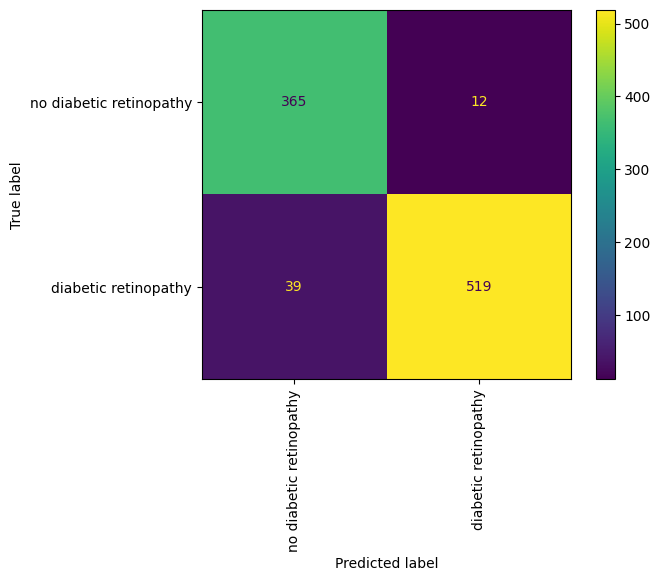

In [459]:
cm = confusion_matrix(bin_y_true,bin_y_pred)
plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no diabetic retinopathy','diabetic retinopathy'])
disp.plot(xticks_rotation='vertical')
plt.show()